# Problem Set #5
- MACS 30150, Dr. Evans 
- Name: Kento Yoshizawa (CNET: kyoshizawa) 
- Date: February 12, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intgr
import scipy.optimize as opt
from scipy import stats, special
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Question 1.

In [2]:
incomes = np.loadtxt('data/incomes.txt')

### (a) Plotting a histogram

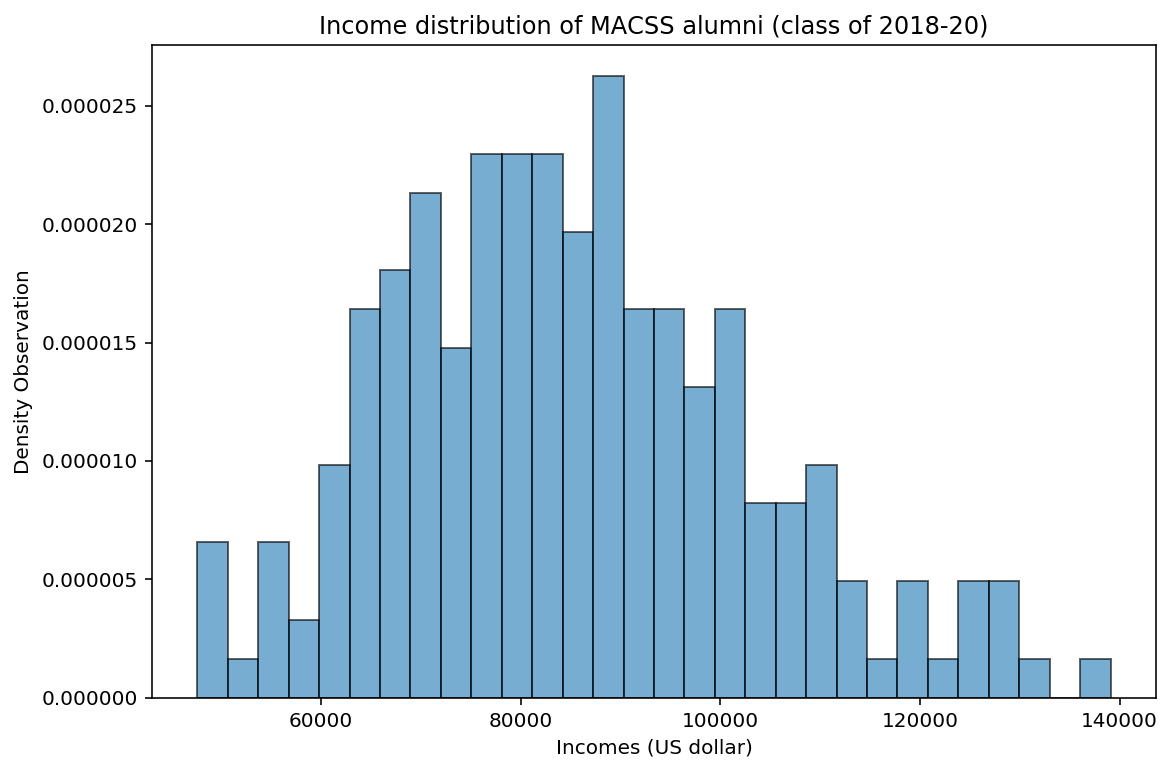

In [3]:
fig = plt.figure(figsize = (9,6))

counts, bins_edge, _ = plt.hist(incomes, 30, density = True, edgecolor = 'k', alpha = 0.6)
plt.title('Income distribution of MACSS alumni (class of 2018-20)')
plt.xlabel('Incomes (US dollar)')
plt.ylabel('Density Observation');

### (b) With 2 moments
#### - Specification of the model
The model we want to fit and estimate parameters is the lognormal $LN(x;\mu,\sigma)$ distribution.

$$ \text{(LN):}\quad f(x;\mu,\sigma) = \frac{1}{x\sigma\sqrt{2\pi}}e^{-\frac{[\ln(x)-\mu]^2}{2\sigma^2}},\quad x\in(0,\infty), \:\mu\in(-\infty,\infty),\: \sigma>0 $$


In [4]:
def lognorm_pdf(xvals, mu, sigma):
    pdf_vals = (1 / (xvals * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma ** 2)))
    
    return pdf_vals

#### - Specification of the moments and moment error function

We use the average income and standard deviation of income as the moments.

In [5]:
def data_2moments(xvals):
    data_mean = np.mean(xvals)
    data_var  = np.var(xvals)
    
    return np.array([data_mean, data_var])

In [6]:
def ln_2moments(mu, sigma, intrv):
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma)
    (model_mean, m_m_err) = intgr.quad(xfx, *intrv)
    
    x2fx = lambda x: ((x - model_mean) ** 2) * lognorm_pdf(x, mu, sigma) 
    (model_var, v_m_err) = intgr.quad(x2fx, *intrv)
        
    return np.array([model_mean, model_var])

In [7]:
def ln_2err_vec(xvals, mu, sigma, intrv, simple):
    data_moms = data_2moments(xvals)
    
    model_moms = ln_2moments(mu, sigma, intrv)
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    
    return err_vec

#### - Performing GMM estimation

Perform GMM estimation with identity matrix.

In [8]:
def criterion_2moms(params, *args):
    mu, sigma = params
    xvals, intrv, W = args
    err = ln_2err_vec(xvals, mu, sigma, intrv, simple = False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [9]:
## Initial guess 
mu_init = np.log(np.mean(incomes))
sig_init = 0.5
params_init = np.array([mu_init, sig_init])

## Set identity matrix as weighting matrix
W_hat = np.eye(2)

## Set GMM arguments
intrv = (0, 1.4e+5)
gmm_args = (incomes, intrv, W_hat)

## Optimization
results_2m = opt.minimize(criterion_2moms, params_init, args=(gmm_args), 
                          method = 'L-BFGS-B', bounds = ((None, None),(1e-7, None)))
results_2m

      fun: 1.3310696694952247e-11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.09188468e-06, -4.43644460e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 10
   status: 0
  success: True
        x: array([11.34926212,  0.21876366])

In [10]:
print('Estimated values\n  - mu   : {0:.4f}\n  - sigma: {1:.4f}'.format(*results_2m.x))
print('The value of the minimized criterion function: {}'.format(results_2m.fun))

Estimated values
  - mu   : 11.3493
  - sigma: 0.2188
The value of the minimized criterion function: 1.3310696694952247e-11


#### - Plotting the distribution implied from GMM estimation of the model

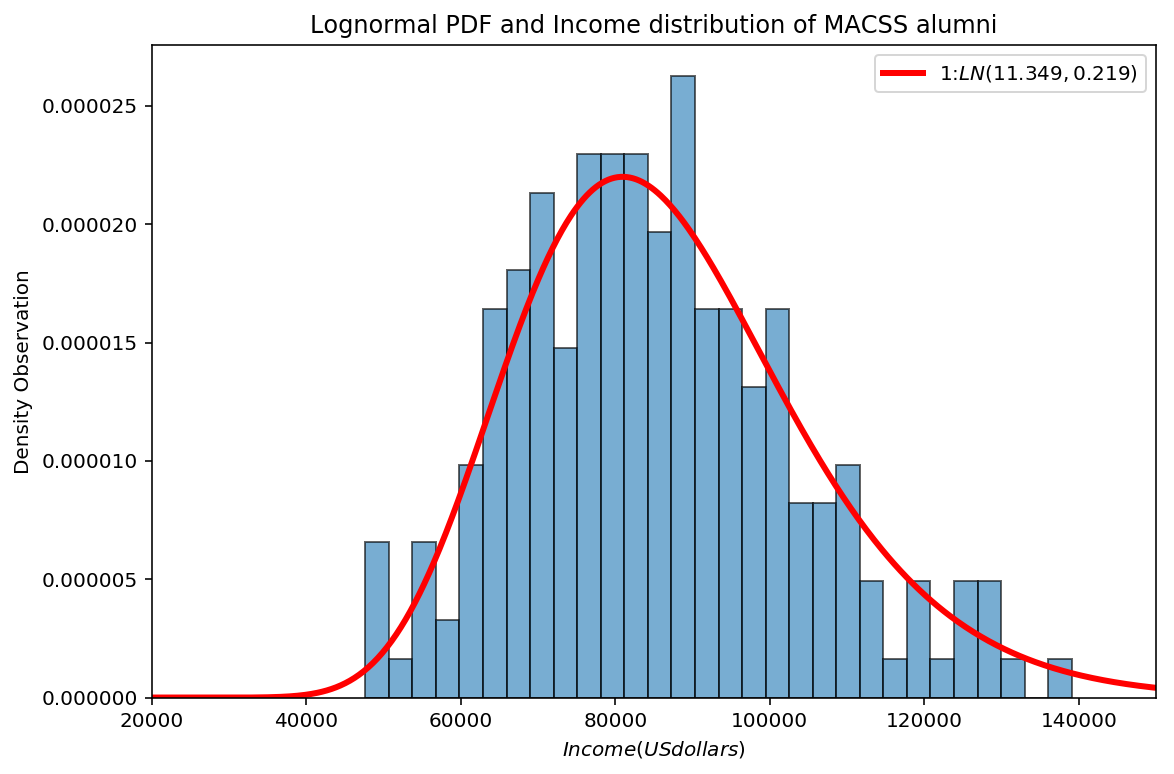

In [11]:
xvals = np.linspace(1e-7, 2e+5, 1000)

fig = plt.figure(figsize = (9,6))

## Histogram
counts, bins_edge, _ = plt.hist(incomes, 30, density = True, edgecolor = 'k', alpha = 0.6)
plt.title('Lognormal PDF and Income distribution of MACSS alumni')
plt.xlabel('$Income (US dollars)$')
plt.ylabel('Density Observation')
plt.xlim(2e+4, 1.5e+5)

## Overlay
plt.plot(xvals,lognorm_pdf(xvals, *results_2m.x), linewidth = 3, 
         c = 'r', label = '1:$LN({0:.3f}, {1:.3f})$'.format(*results_2m.x))

plt.legend();

In [12]:
print('Data moments : mu = {0:.5f}, sigma = {1:.4f}'.format(*data_2moments(incomes)))
print('Model moments: mu = {0:.5f}, sigma = {1:.4f}'.format(*ln_2moments(*results_2m.x, intrv)))

Data moments : mu = 85276.82361, sigma = 323731572.2295
Model moments: mu = 85276.51317, sigma = 323731493.9282


### (c) With 2 moments and 2 step weighting matrix
#### - Second step: Calculating weighting matrix
Step 1 has already done in part (b). Step 2 is the following:

In [13]:
def ln_2Err_mat(xvals, mu, sigma, intrv, simple):
    N = len(xvals)
    
    Err_mat = np.zeros((2, N))
    model_mean, model_var = ln_2moments(mu, sigma, intrv)
    data_mean, _ = data_2moments(xvals)
    
    if simple:
        Err_mat[0, :] = xvals - model_mean
        Err_mat[1, :] = ((data_mean - xvals) ** 2) - model_var
    else:
        Err_mat[0, :] = xvals - model_mean / model_mean
        Err_mat[1, :] = (((data_mean - xvals) ** 2) - model_var) / model_var
    
    return Err_mat

In [14]:
Err_mat = ln_2Err_mat(incomes, *results_2m.x, intrv, False)
VCV = (1 / incomes.shape[0]) * (Err_mat @ Err_mat.T)
W_hat2 = np.linalg.inv(VCV)
print('Two-step estimator for the optimal weighting matrix:\n', W_hat2)

Two-step estimator for the optimal weighting matrix:
 [[ 1.32222766e-10 -5.41823181e-07]
 [-5.41823181e-07  5.15681294e-01]]


#### - Re-estimate GMM estimators

Re-estimate the GMM estimator using the optimal two-step weighting matrix.

In [15]:
## Initial guess
params_init = results_2m.x

## Set GMM arguments
gmm_args2 = (incomes, intrv, W_hat2)

## Optimization
results_2m2 = opt.minimize(criterion_2moms, params_init, args=(gmm_args2),
                          method='L-BFGS-B', bounds=((None, None), (1e-7, None)))
results_2m2

      fun: 3.01672587926168e-14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.13911041e-07, -1.47158685e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([11.34926212,  0.21876366])

In [16]:
print('Estimated values\n  - mu   : {0:.4f}\n  - sigma: {1:.4f}'.format(*results_2m2.x))
print('The value of the minimized criterion function: {}'.format(results_2m2.fun))

Estimated values
  - mu   : 11.3493
  - sigma: 0.2188
The value of the minimized criterion function: 3.01672587926168e-14


#### - Plotting the distribution implied from GMM estimation of the model

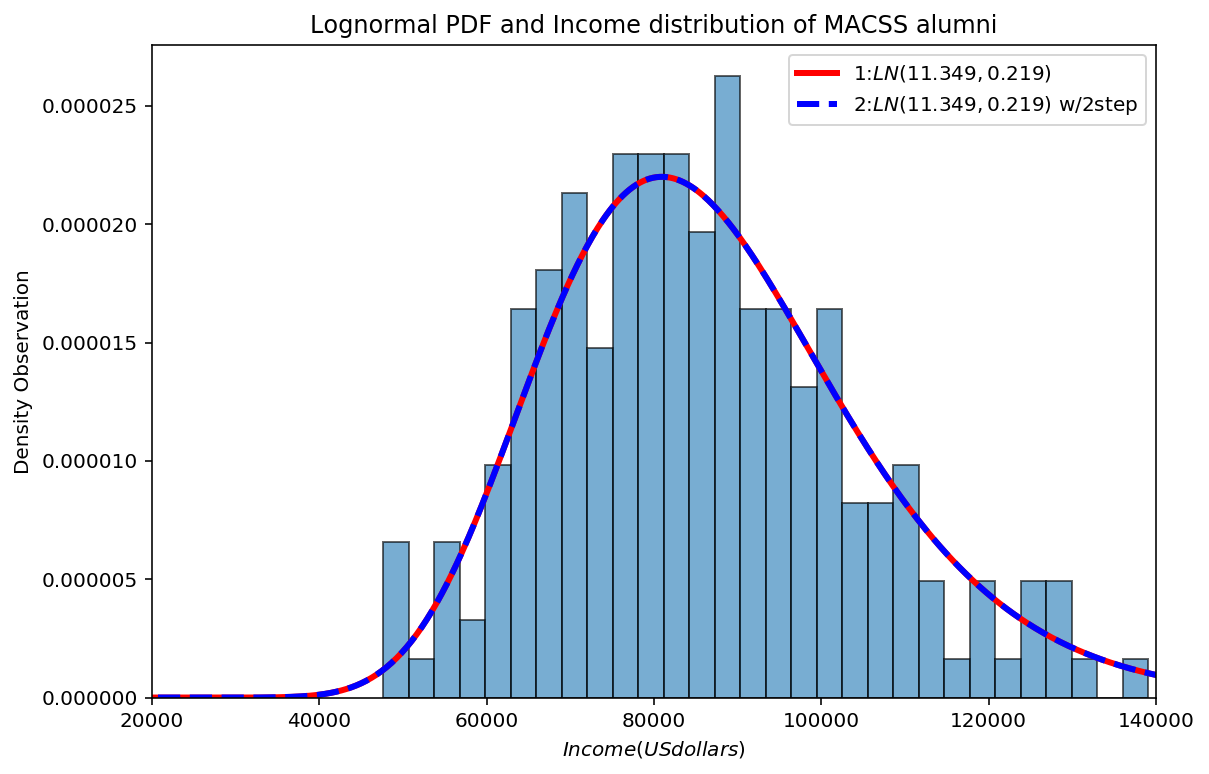

In [17]:
fig = plt.figure(figsize = (9,6))

## Histogram
counts, bins, _ = plt.hist(incomes, 30, density = True, edgecolor = 'k', alpha = 0.6)
plt.title('Lognormal PDF and Income distribution of MACSS alumni')
plt.xlabel('$Income (US dollars)$')
plt.ylabel('Density Observation')
plt.xlim(2e+4, 1.4e+5)

## Overlay
plt.plot(xvals,lognorm_pdf(xvals, *results_2m.x), linewidth = 3, 
         c = 'r', label = '1:$LN({0:.3f}, {1:.3f})$'.format(*results_2m.x))
plt.plot(xvals,lognorm_pdf(xvals, *results_2m2.x), linewidth = 3, ls = '--',
         c = 'b', label = '2:$LN({0:.3f}, {1:.3f})$ w/2step'.format(*results_2m2.x))

plt.legend();

In [18]:
print('Data moments : mu = {0:.5f}, sigma = {1:.4f}'.format(*data_2moments(incomes)))
print('Model moments: mu = {0:.5f}, sigma = {1:.4f}'.format(*ln_2moments(*results_2m2.x, intrv)))

Data moments : mu = 85276.82361, sigma = 323731572.2295
Model moments: mu = 85276.51317, sigma = 323731493.9282


### (d) With 3 moments
#### - Specification of the moments and moment error function

We use the three percentile of income as the moments.

In [19]:
bins = np.array([0, 7.5e+4, 1e+5, 1.4e+5])

In [20]:
def data_3moments(xvals, bins):
    weights = np.ones_like(xvals)/(xvals.shape[0])        
    data_moments, b = np.histogram(xvals, bins = bins, weights = weights)
    
    return data_moments

In [21]:
def ln_3moments(mu, sigma, bins):
    model_moments = []
    
    for i in range(len(bins)-1):
        fx = lambda x: lognorm_pdf(x, mu, sigma)
        (mom, m_err) = intgr.quad(fx, bins[i], bins[i+1])
        model_moments.append(mom)
        
    return np.array(model_moments)

In [22]:
def ln_3err_vec(xvals, mu, sigma, bins, simple):
    data_moms = data_3moments(xvals, bins)
    
    model_moms = ln_3moments(mu, sigma, bins)
    
    if simple:
        err_vec = model_moms - data_moms
    else:
        err_vec = (model_moms - data_moms) / data_moms
    
    return err_vec

#### - Performing GMM estimation

Perform GMM estimation with identity matrix.

In [23]:
def criterion_3moms(params, *args):
    mu, sigma = params
    xvals, bins, W = args
    err = ln_3err_vec(xvals, mu, sigma, bins, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [24]:
## Initial guess 
mu_init = np.log(np.mean(incomes))
sig_init = 0.5
params_init = np.array([mu_init, sig_init])

## Set identity matrix as weighting matrix
W_hat = np.eye(3)

## Set GMM arguments
gmm_args = (incomes, bins, W_hat)

## Optimization
results_3m = opt.minimize(criterion_3moms, params_init, args=(gmm_args), method = 'L-BFGS-B', 
                         bounds = ((None, None),(1e-7, None)))
results_3m

      fun: 0.00018797487088237206
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.02080345e-07,  9.57624279e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 16
   status: 0
  success: True
        x: array([11.33862142,  0.21374889])

In [25]:
print('Estimated values\n  - mu   : {0:.4f}\n  - sigma: {1:.4f}'.format(*results_3m.x))
print('The value of the minimized criterion function: {}'.format(results_3m.fun))

Estimated values
  - mu   : 11.3386
  - sigma: 0.2137
The value of the minimized criterion function: 0.00018797487088237206


#### - Plotting the distribution implied from GMM estimation of the model

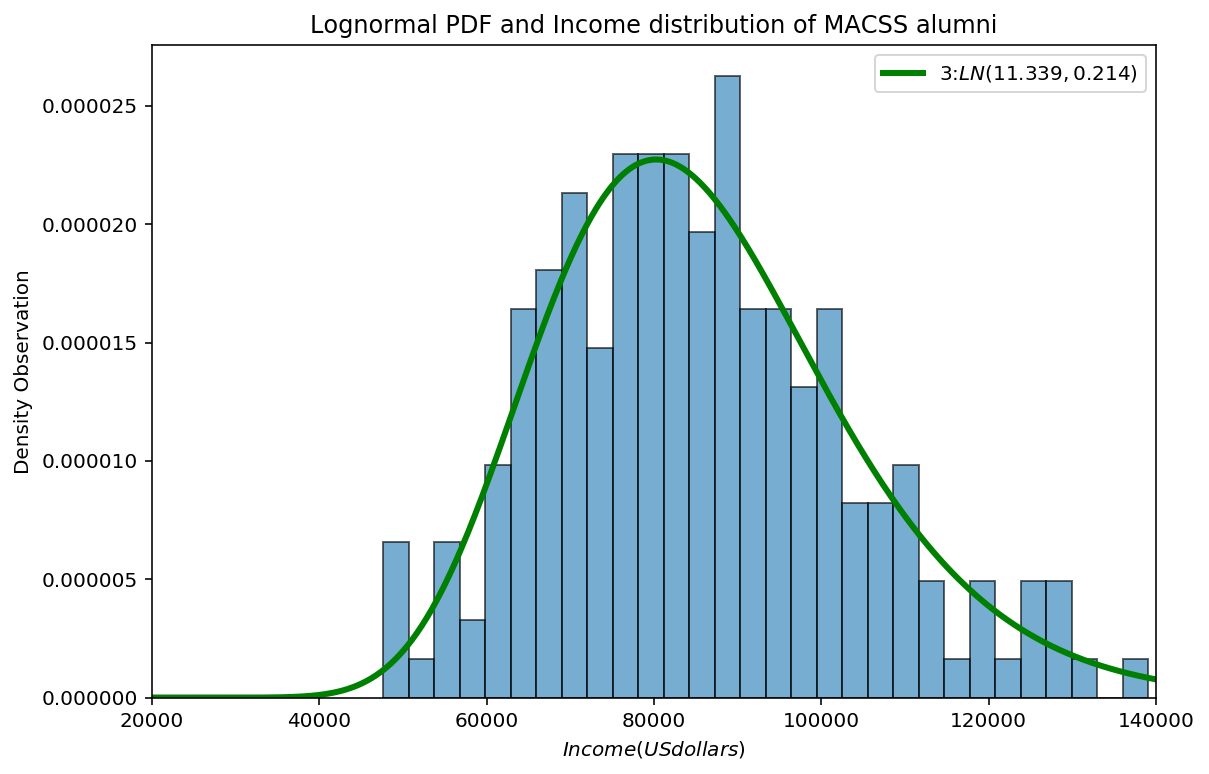

In [26]:
fig = plt.figure(figsize = (9,6))

## Histogram
counts, bins_edge, _ = plt.hist(incomes, 30, density = True, edgecolor = 'k', alpha = 0.6)
plt.title('Lognormal PDF and Income distribution of MACSS alumni')
plt.xlabel('$Income (US dollars)$')
plt.ylabel('Density Observation')
plt.xlim(2e+4, 1.4e+5)

## Overlay
plt.plot(xvals,lognorm_pdf(xvals, *results_3m.x), linewidth = 3,
         c = 'g', label = '3:$LN({0:.3f}, {1:.3f})$'.format(*results_3m.x))
plt.legend();

In [27]:
print('Data moments:\n ~75k: {0:.1%}, 75k~100k: {1:.1%}, 100k~: {2:.1%}'.format(*data_3moments(incomes,bins)))
print('Model moments:\n ~75k: {0:.1%}, 75k~100k: {1:.1%}, 100k~: {2:.1%}'.format(*ln_3moments(*results_3m.x, bins)))

Data moments:
 ~75k: 30.0%, 75k~100k: 50.0%, 100k~: 20.0%
Model moments:
 ~75k: 29.8%, 75k~100k: 49.5%, 100k~: 19.9%


### (e) With 3 moments and 2 step weighting matrix
#### - Second step: Calculating weighting matrix
Step 1 has already done in part (b). Step 2 is the following:

In [28]:
def ln_3Err_mat(xvals, mu, sigma, bins, simple):
    N = len(xvals)
    R = len(bins)-1
    
    Err_mat = np.zeros((R, N))
    model_moms = ln_3moments(mu, sigma, bins)
    
    for r in range(R):
        group = ((xvals >= bins[r]) & (xvals < bins[r+1]))
        if simple:
            Err_mat[r,:] = (model_moms[r] - group)
        else:
            Err_mat[r,:] = (model_moms[r]- group) / group
    
    return Err_mat

In [29]:
Err_mat = ln_3Err_mat(incomes, *results_3m.x, bins, True)
VCV = (1 / incomes.shape[0]) * (Err_mat @ Err_mat.T)
W_hat2 = np.linalg.inv(VCV)
print('Two-step estimator for the optimal weighting matrix:\n', W_hat2)

Two-step estimator for the optimal weighting matrix:
 [[14063.85874118 14060.0923711  14060.742044  ]
 [14060.0923711  14061.65933435 14060.30900725]
 [14060.742044   14060.30900725 14065.95868015]]


#### - Re-estimate GMM estimators

Re-estimate the GMM estimator using the optimal two-step weighting matrix.

In [30]:
## Initial guess
params_init = results_3m.x

## Set GMM arguments
gmm_args2 = (incomes, bins, W_hat2)

## Optimization
results_3m2 = opt.minimize(criterion_3moms, params_init, args=(gmm_args2),
                          method='L-BFGS-B', bounds=((None, None), (1e-7, None)))
results_3m2

      fun: 0.007129197129190705
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.37635563e-05, 3.97202236e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 11
   status: 0
  success: True
        x: array([11.33836986,  0.22158858])

In [31]:
print('Estimated values\n  - mu   : {0:.4f}\n  - sigma: {1:.4f}'.format(*results_3m2.x))
print('The value of the minimized criterion function: {}'.format(results_3m2.fun))

Estimated values
  - mu   : 11.3384
  - sigma: 0.2216
The value of the minimized criterion function: 0.007129197129190705


#### - Plotting the distribution implied from GMM estimation of the model

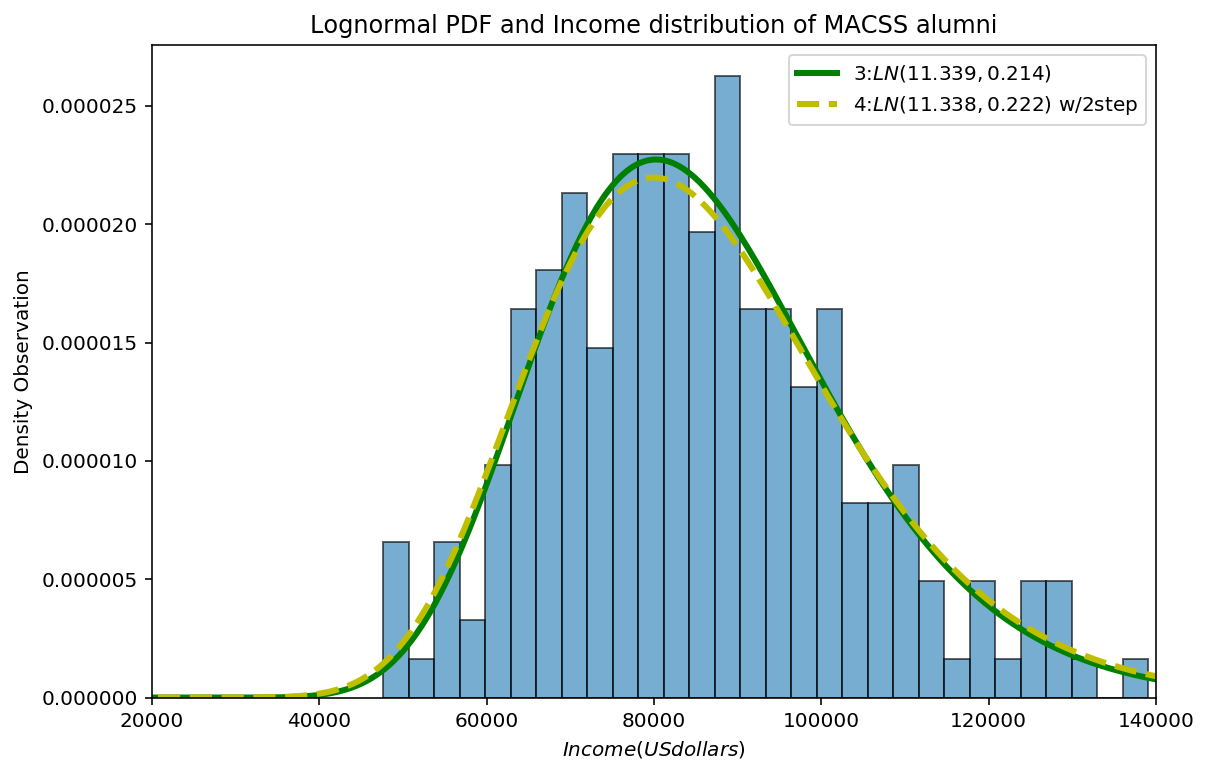

In [32]:
fig = plt.figure(figsize = (9,6))

## Histogram
counts, bins_edge, _ = plt.hist(incomes, 30, density = True, edgecolor = 'k', alpha = 0.6)
plt.title('Lognormal PDF and Income distribution of MACSS alumni')
plt.xlabel('$Income (US dollars)$')
plt.ylabel('Density Observation')
plt.xlim(2e+4, 1.4e+5)
## Overlay
plt.plot(xvals,lognorm_pdf(xvals, *results_3m.x), linewidth = 3,
         c = 'g', label = '3:$LN({0:.3f}, {1:.3f})$'.format(*results_3m.x))
plt.plot(xvals,lognorm_pdf(xvals, *results_3m2.x), linewidth = 3,ls = '--',
         c = 'y', label = '4:$LN({0:.3f}, {1:.3f})$ w/2step'.format(*results_3m2.x))
plt.legend();

In [33]:
print('Data moments:\n ~75k: {0:.1%}, 75k~100k: {1:.1%}, 100k~: {2:.1%}'.format(*data_3moments(incomes,bins)))
print('Model moments:\n ~75k: {0:.1%}, 75k~100k: {1:.1%}, 100k~: {2:.1%}'.format(*ln_3moments(*results_3m2.x, bins)))

Data moments:
 ~75k: 30.0%, 75k~100k: 50.0%, 100k~: 20.0%
Model moments:
 ~75k: 30.5%, 75k~100k: 48.0%, 100k~: 20.5%


### (f) Evaluation

In [34]:
import pandas as pd
pd.DataFrame(
        data = np.array([[*results_2m.x, results_2m.fun],
                         [*results_2m2.x, results_2m2.fun],
                         [*results_3m.x, results_3m.fun],
                         [*results_3m2.x, results_3m2.fun]]),
        index = ['2 moments','2 moments w/ $W_{2step}$','3 moments', '3 moments w/ $W_{2step}$'],
        columns = ['$\mu_{GMM}$', '$\sigma_{GMM}$', 'Crit.fun.']
        )

,$\mu_{GMM}$,$\sigma_{GMM}$,Crit.fun.
2 moments,11.349262,0.218764,1.331070e-11
2 moments w/ $W_{2step}$,11.349262,0.218764,3.016726e-14
3 moments,11.338621,0.213749,1.879749e-04
3 moments w/ $W_{2step}$,11.338370,0.221589,7.129197e-03


Since all the four estimations are very similar to each other and every value of the criterion function is so tiny, we can say every estimation fits the data very well. 

Strictly speaking, we can't compare the values of the criterion function among the four estimation because the models from part (c) and part (e) use different weighting matrix (i.e., two-step weighting matrix). However, if we should choose the best one, **the estimation with 2 moments and two-step weighting matrix** (that is, the estimation from part (c)) might do the best job.

---
## Question 2.

In [35]:
df = pd.read_csv('data/sick.txt')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [36]:
X = df.values[:,1:]
y = df.values[:,0]

In [37]:
def lr_moments(params, X):
    N = X.shape[0]
    X = np.hstack((np.ones(N).reshape(N,-1), X))

    model_moment = X @ params
    
    return model_moment

In [38]:
def lr_err_vec(params, X, y):
    data_moms = y
    model_moms = lr_moments(params, X)
    
    err_vec = data_moms - model_moms
    
    return err_vec

In [39]:
def criterion_lr(params, *args):
    X, y, W = args
    err = lr_err_vec(params, X, y)
    crit_val = err.T @ W @ err
    
    return crit_val

In [40]:
## Initial guesses
b0_init = 1.
b1_init = 1.  ## the older, the easier get sick so set positive
b2_init = 1.  ## the more children, the easier get sick so set positive
b3_init = -1. ## the lower temp, the easier get sick so set negative
params_init = np.array([b0_init, b1_init, b2_init, b3_init])

## Set identity matrix as weighting matrix
W_hat = np.eye(200)

## Set GMM arguments
gmm_args = (X, y, W_hat)

result_lr = opt.minimize(criterion_lr, params_init, args = (gmm_args), method = 'L-BFGS-B')
result_lr

      fun: 0.001821289818494825
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.12120121e-07,  8.25069180e-06,  1.22102849e-06, -5.03705151e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 75
      nit: 9
   status: 0
  success: True
        x: array([ 0.25164475,  0.01293345,  0.40050117, -0.0099917 ])

In [41]:
print('Estimated values for coef.: beta0 = {0:.4f}, beta1 = {1:.4f}, beta2 = {2:.4f}, beta3 = {3:.4f}'.format(*result_lr.x))
print('The value of the minimized criterion function: {}'.format(result_lr.fun))

Estimated values for coef.: beta0 = 0.2516, beta1 = 0.0129, beta2 = 0.4005, beta3 = -0.0100
The value of the minimized criterion function: 0.001821289818494825
